# <center> Methane-Air Cantera Calculations


###  <center> Submitted to Data in Brief <br>  Tanja Pelzmann
    
 contact: tanja.pelzmann@polymtl.ca


<div class="alert alert-block alert-info">
<a name = "note"></a>PLEASE NOTE: <br>

The jupyternotebook _ThermoPropertiesNASA.ipynb_ needs to be stored in same folder as this notebook to correctly execute the code.

**Basic packages required for labs**

In [2]:
%matplotlib inline
import cantera as ct 
import numpy as np
from scipy.optimize import fsolve 
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools

from IPython.display import HTML, display
import pandas as pd

import yaml
yaml.warnings({'YAMLLoadWarning': False})
#important note: the print output in the file is executed as well
%run ThermoPropertiesNASA.ipynb   # import ThermoPropertiesNASA, needs to be stored in same folder

## Combustion $-$ CH$_4$ + Air Flames

The adiabatic flame temperature as a function of fuel-to-air ratio is calculed. 

### Global chemical reaction equations

All herein presented calculations refer to an inital state of the reactants at 300 K and 1 atm. Air is defined as a mixture of oxygen and nitrogen with a 1/3.76 ratio of moles.<br>
#### Stoichometric condition
$
\begin{align}
\rm
CH_4 + 2(O_2 + 3.76 N_2) \longrightarrow  CO_2 + 2 H_2O + 7.5 N_2
\end{align}
$ <br>

#### Lean Condition 
The reaction equation for lean conditions is obtained by applying excess air as a function of $\phi$ :
$\phi CH_4 + 2(O_2 + 3.76 N_2) \rightarrow \phi CO_2 + 2\phi H_2O + 2(1-\phi)O_2 + 7.52 N_2$ <br>

The number of moles of species per unit volume is completely determined by the theoretical combustion of the process and hence independent of temperature and pressure. 


#### Rich Condition 
For the rich side, it is taken into account that C is oxidized first into CO then reacts in a second step to form $\rm CO_2$. Conservation laws, Gaussian eliminatio and a fixed molar ratio $ \rm X_{CO_2}/X_{CO} = 9$ yields the coefficients: <br>

$\phi CH_4 + 2(O_2 + 3.76 N_2) \rightarrow 0.9 \phi CO_2 + 0.1 \phi CO + (-1.9\phi +4) H_2O + (3.9 \phi - 4) H_2 + 7.52 N_2$

### <a name = "subsec:Part1-tad"></a>1.3  Adiabatic Flame Temperature as a Function of Fuel-to-Air Ratio

Using that the enthalpy of combustion equals the difference between the enthalpy of the product<br>
$
\rm
h_c = \sum_{i}(\nu_{i,p} h_{f i,p}^0) - \sum_{i}(\nu_{i,r} h_{f i,r}^0)
$<br>
where the subscripts refer to the product and reactants respectively. <br>
Neglecting any work interactions, or change in kinetic or potential energies, the heat release due to change of chemical energy will raise the temperature of the products and be transferred to the sourroundings. Further neglecting this heat loss to the sourroundings, the theoretical maximum temperature of the products is referred to as adiabatic flame temperature. 

$ \rm H_{prod}\quad = \quad H_{react}\qquad$ or <br>
$\rm \sum_{i}(N_{p} (h_{f i,p}^0 + h_{p} - h_{i,p}^0) =  \sum_{i}(N_{r} (h_{f i,r}^0 + h_{r} - h_{i,r}^0)$<br>

with: <br>

$\rm N_{p} \dots \quad$ the molar concentration coefficient for products (p) and reactants (r) <br>
$\rm h_{f i,p}^0 \dots \quad$ the enthalpy of formation at the standard reference state of 298.15 K and 1 atm <br>
$ \rm h_{p}\dots \quad$  the sensible enthalpy at a given state <br> 
$\rm h_{i,p}^0 \dots \quad$ the sensible enthalpy at the standard reference state of 298.15 K and 1 atm <br>


In total the following assumptions were made:<br>
* The combustion of methane is considered a steady-flow process
* The combustion chamber is adiabatic (hence no exchange of heat or matter with the sourrunding)
* No work interaction (W = 0)
* Air and all combustion gases are treated as an ideal gas
* All changes in kinetic or potential energy are neglected

The fuel-to-air ratio is varied between 0.7 and 1.45 and the adiabatic flame temperature calculated for each step using the above formula. The values for the entropy were again taken from them *thermoDataNASA-9.yaml* file. While the entropy for the reactants remains the same regardless of the fuel-to-air ratio, the entropy of the products requires a case destinction for stoichometric, complete combustion with excess air, and incomplete combustion with defeciency air.    


### Methane combustion function taking the Fuel/Air ratio into account

This function calculates the theoretical adiabatic flame temperature. 

In [3]:
def methane_combustion( T, *params ):
    ( phi, ) = params
    
    if phi < 1:
        N_i = (phi,2*phi,2*(1- phi),7.52)   #molar concentration coefficient 

        H_prod_T0 = (N_i[0] * CO2.h_mole(T0) + N_i[1] * H2O.h_mole(T0) + \
                  N_i[2]* O2.h_mole(T0) + N_i[3] * N2.h_mole(T0))
        H_prod_T = (N_i[0] * CO2.h_mole(T) + N_i[1] * H2O.h_mole(T) + \
                   N_i[2] * O2.h_mole(T) + N_i[3] * N2.h_mole(T))
        return ((H_prod_T - H_prod_T0) - (H_react - H_prod_T0))
    
    elif phi >1:
        N_i = (0.9*phi,0.1*phi,(-1.9*phi +4),(3.9*phi -4),7.52)  #molar concentration coefficient
            
        H_prod_T0 = (N_i[0] * CO2.h_mole(T0) + N_i[1] * CO.h_mole(T0) + N_i[2] * \
                    H2O.h_mole(T0) + N_i[3] * H2.h_mole(T0) + N_i[4]* N2.h_mole(T0))
        H_prod_T = (N_i[0] * CO2.h_mole(T) + N_i[1] * CO.h_mole(T) + N_i[2] * \
                    H2O.h_mole(T) + N_i[3] * H2.h_mole(T) + N_i[4]* N2.h_mole(T))

        return ((H_prod_T - H_prod_T0) - (H_react - H_prod_T0))
          
    else:
        N_i = (1,2,7.52) #molar concentration coefficient 
        H_prod_T0 = N_i[0] * CO2.h_mole(T0) + N_i[1] * H2O.h_mole(T0) + N_i[2] * N2.h_mole(T0)
        H_prod_T = N_i[0] * CO2.h_mole(T) + N_i[1] * H2O.h_mole(T) + N_i[2] * N2.h_mole(T)
               
        return ((H_prod_T - H_prod_T0) - (H_react - H_prod_T0))

### Main loop calculating adiabatic temperature, velocity, density and mixture fractions

In [6]:
# 1.3 Main code
# note: NASA numbering starts at a1 and Cantera starts at a0, which is used:  thus a0...a8

############# PREAMBEL #################
# simulation settings
grid0 = [0.0, 0.001, 0.01, 0.02, 0.029, 0.03] # in meter
tol_ss = [1.0e-5, 1.0e-13] # [steady-state problem
tol_ts = [1.0e-4, 1.0e-13] # time stepping
loglevel = 0 # diagnostic output (0 to 8)
refine_grid = True #enable refinement

#setup cantera object
p0 = ct.one_atm # pressure [Pa]
T0 = 300.0 # unburned gas temperature [K]
FAR = np.array([0.70, 0.90, 1.00,1.10, 1.20, 1.30, 1.40, 1.45]) #fuel-air-ratio 


gas = ct.Solution('gri30.cti', 'gri30_mix') # IdealGasMix object for mixture properties

# create instances from thermo class for theoretical solution
CO2 = thermo('CO2',44.00950)
H2O = thermo('H2O',18.01528)
CH4 = thermo('CH4',16)
CO = thermo('CO',28.01010)
O2 = thermo('O2',31.99880)
N2 = thermo('N2',28.01340)
H2 = thermo('H2',2.01588)


#initialize Temperature arrays
T_ad_comp = np.zeros(len(FAR)) #theoretical calculation
T_ad_ctra = np.zeros(len(FAR)) #cantera solution
u_av = np.zeros(len(FAR)) #mixture averaged flow speed of the flame
props = []

##### MAIN LOOP ######



for i,phi in enumerate(FAR):
        
        # theoretical solution: Enthalpy of formation for reactants independent of FAR at all times:
        H_react = phi*CH4.h_mole(T0) + 2*O2.h_mole(T0) + 7.52*N2.h_mole(T0)
        T_ad_comp[i] = fsolve(methane_combustion,298.15,(phi,))  #start at reference state
        
        ##Cantera solution:
        gas.TPX = T0, p0, 'CH4:%f, O2:2, N2:7.52' % phi
        gas.equilibrate('HP')
        T_ad_ctra[i] = gas.T
        
        # Flame object
        f = ct.FreeFlame(gas, grid0)
        f.flame.set_steady_tolerances(default=tol_ss)
        f.flame.set_transient_tolerances(default=tol_ts)

        # Set properties of the upstream fuel-air mixture
        f.inlet.T = T0
        f.inlet.X = 'CH4:%f, O2:2, N2:7.52' % phi
        
        #refine solver and enable energy equation
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)
        f.energy_enabled = True
        f.solve(loglevel=loglevel, refine_grid=refine_grid)
        f.save('ch4_adiabatic_GRI.xml', 'energy','solution with mixture-averaged transport')
        #f.show_solution()
        u_av[i] = f.u[0]
        #print('mixture-averaged flamespeed = {0:7f} m/s'.format(f.u[0]))
        
        #create individual csv files : velocity, temperature, density, mole fractions
        filename = 'ch4_phi%3s_GRI_mix.csv' %str(phi).replace('.','')
        f.write_csv(filename, quiet=False) 
        


Solution saved to file ch4_adiabatic_GRI.xml as solution energy.
Solution saved to 'ch4_phi 07_GRI_mix.csv'.
Solution saved to file ch4_adiabatic_GRI.xml as solution energy.
Solution saved to 'ch4_phi 09_GRI_mix.csv'.
Solution saved to file ch4_adiabatic_GRI.xml as solution energy.
Solution saved to 'ch4_phi 10_GRI_mix.csv'.
Solution saved to file ch4_adiabatic_GRI.xml as solution energy.
Solution saved to 'ch4_phi 11_GRI_mix.csv'.
Solution saved to file ch4_adiabatic_GRI.xml as solution energy.
Solution saved to 'ch4_phi 12_GRI_mix.csv'.
Solution saved to file ch4_adiabatic_GRI.xml as solution energy.
Solution saved to 'ch4_phi 13_GRI_mix.csv'.
Solution saved to file ch4_adiabatic_GRI.xml as solution energy.
Solution saved to 'ch4_phi 14_GRI_mix.csv'.
Solution saved to file ch4_adiabatic_GRI.xml as solution energy.
Solution saved to 'ch4_phi145_GRI_mix.csv'.


### Data post-processing

Alternatvely, instead of creating the individual data files with the code above, load the csv files provided in the mendeley repository into a pandas dataframe object.

In [109]:
#csv files contain empty rows but by default, read_csv(...) function skips blank line
import os
import glob

FAR = np.array([0.70, 0.90, 1.00,1.10, 1.20, 1.30, 1.40, 1.45]) #fuel-air-ratio 
path = "my_dir_full_path"
allFiles = glob.glob(os.path.join(path,"*.csv"))

dfs = []

for file_,phi in zip(allFiles,FAR):
    df = pd.read_csv(file_,index_col=None)
    df['phi'] = phi #use fuel to air ratio as classifier
    dfs.append(df)

# Concatenate all data into one DataFrame
Canteradf = pd.concat(dfs, ignore_index=True)
Canteradf.rename(columns={'z (m)':'z', 'u (m/s)':'u','V (1/s)':'V','T (K)':'T','rho (kg/m3)':'rho'}, inplace=True)

Canteradf.head()

,z,u,V,T,rho,H2,H,O,O2,OH,...,HOCN,HNCO,NCO,N2,AR,C3H7,C3H8,CH2CHO,CH3CHO,phi
0,0.000000,0.194513,0.0,300.0,1.136338,2.030498e-09,-1.330883e-14,7.959368e-15,0.195695,-2.164909e-14,...,2.811326e-21,-2.967180e-17,-5.522456e-17,0.735812,3.564730e-112,6.371955e-17,-1.456918e-17,-7.477014e-29,4.874482e-17,0.7
1,0.000500,0.194513,0.0,300.0,1.136338,4.557514e-09,-1.840600e-18,3.169637e-14,0.195695,-5.569412e-16,...,2.811350e-21,-2.967178e-17,-3.946011e-16,0.735812,5.558752e-112,6.371972e-17,-1.456917e-17,-6.163325e-28,4.874526e-17,0.7
2,0.001000,0.194513,0.0,300.0,1.136338,1.022947e-08,-1.922447e-22,3.174900e-14,0.195695,2.023097e-18,...,2.811528e-21,-2.967162e-17,-3.946026e-16,0.735812,7.480001e-112,6.371990e-17,-1.456906e-17,-8.048412e-28,4.874888e-17,0.7
3,0.002125,0.194513,0.0,300.0,1.136338,4.880056e-08,6.065210e-25,3.085583e-14,0.195695,1.789815e-17,...,2.815932e-21,-2.966772e-17,-3.946024e-16,0.735812,1.141758e-111,6.372035e-17,-1.456537e-17,-9.436664e-28,4.885356e-17,0.7
4,0.003250,0.194513,0.0,300.0,1.136338,1.953780e-07,6.115046e-25,2.967580e-14,0.195695,1.743123e-17,...,2.881583e-21,-2.960926e-17,-3.946019e-16,0.735812,1.411630e-111,6.372080e-17,-1.449104e-17,-7.450338e-28,5.067222e-17,0.7


The following code creates a subset from the above dataframe considering only a few species of interest. Furthermore, the data is grouped with respect to $\phi$. Since all experimental measurements refer to a position of 15 mm above the grid, the region of interest is defined as 14.5 to 15.5 mm and all calculated values for this position are averaged. The final dataframe _DIBdf_ contains the molar fraction of species, density, velocity and temperature for this region.

In [107]:
# group dataframe and evaluate the species of interest at the height of 15mm
# extract subframe with species of interest

DIBdf = Canteradf[['phi','z','u','V','T','rho','O2','N2','H2O','CO2','CO','H2']]
DIBdf.head(10)

# region of intest: z =15mm
ROI = DIBdf.loc[(DIBdf['z'] >= 0.0145) & (DIBdf['z'] <=0.0155)]
DIBfinal = ROI.groupby('phi').mean()
DIBfinal['Tad'] =np.round(T_ad_ctra,0)
DIBfinal['u_av'] = u_av

DIBfinal

,z,u,V,T,rho,O2,N2,H2O,CO2,CO,H2,Tad,u_av
phi,,,,,,,,,,,,,
0.70,0.015078,1.190827,0.0,1834.999109,0.185613,0.058800,0.735222,0.136197,0.067744,0.000362,0.000153,1839.0,0.194513
0.90,0.015219,2.386146,0.0,2101.037188,0.160060,0.021748,0.717884,0.167611,0.080501,0.005035,0.002042,2134.0,0.338876
1.00,0.015219,2.769281,0.0,2163.222727,0.153743,0.008856,0.706062,0.179081,0.079807,0.013694,0.005869,2226.0,0.379286
1.10,0.015219,2.818213,0.0,2158.468469,0.151640,0.002343,0.691021,0.185490,0.072461,0.028289,0.014031,2210.0,0.382220
1.20,0.015031,2.444591,0.0,2104.257125,0.152549,0.000450,0.673956,0.185860,0.062066,0.045249,0.027376,2137.0,0.334838
1.30,0.015031,1.704201,0.0,2036.806930,0.154433,0.000067,0.656697,0.182229,0.052807,0.060477,0.044354,2057.0,0.237218
1.40,0.015219,0.988982,0.0,1975.550755,0.156104,0.000002,0.640330,0.176595,0.045340,0.073318,0.063387,1980.0,0.139680
1.45,0.015219,0.819879,0.0,1945.360699,0.157380,0.000002,0.634001,0.175488,0.042805,0.076119,0.069235,1942.0,0.116962


### graphical output

#### Adiabatic Flame Temperature

The adiabiatic flame temperature of a fuel is not a unique quantity, but depends on:
1. the degree of the completion of the reaction
2. the state of the reactants
3. the equivalence ratio (i.e. the amount of excess or deficiency air)

As a consequence, all quantities altering the state of the reactants, such as pressure and inital temperature will also affect the adiabatic flame temperature. Incomplete combustion or using excess air will for example also lower the adiabatic temperature. More evidently, the enthalpy itself depends on pressure and temperature and since T$_{ad}$ is calculated based on it, also T$_{ad}$ = f(p,T). 

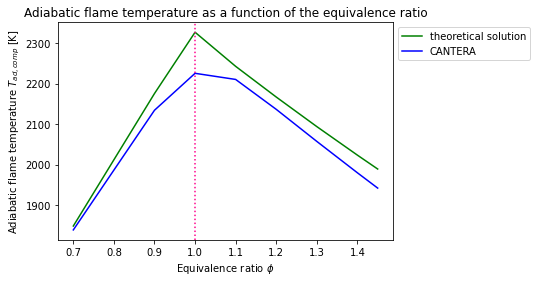

In [9]:
plt.figure(1) 
plt.plot(FAR,T_ad_comp,'g-',label="theoretical solution"); #semicolon to stop output otherwise: _ = plt.plot(a)
plt.plot(FAR, T_ad_ctra,'b-',label = "CANTERA");
plt.axvline(x=1,linestyle=':',color='xkcd:hot pink' )
plt.xlabel('Equivalence ratio $\phi$');
plt.ylabel('Adiabatic flame temperature $T_{ad,comp}$ [K]');
plt.title('Adiabatic flame temperature as a function of the equivalence ratio');
plt.legend(loc=2,bbox_to_anchor=(1, 1));

#### Species and temperature as a function of fuel/air ratio at a vertical distance z = 15 mm

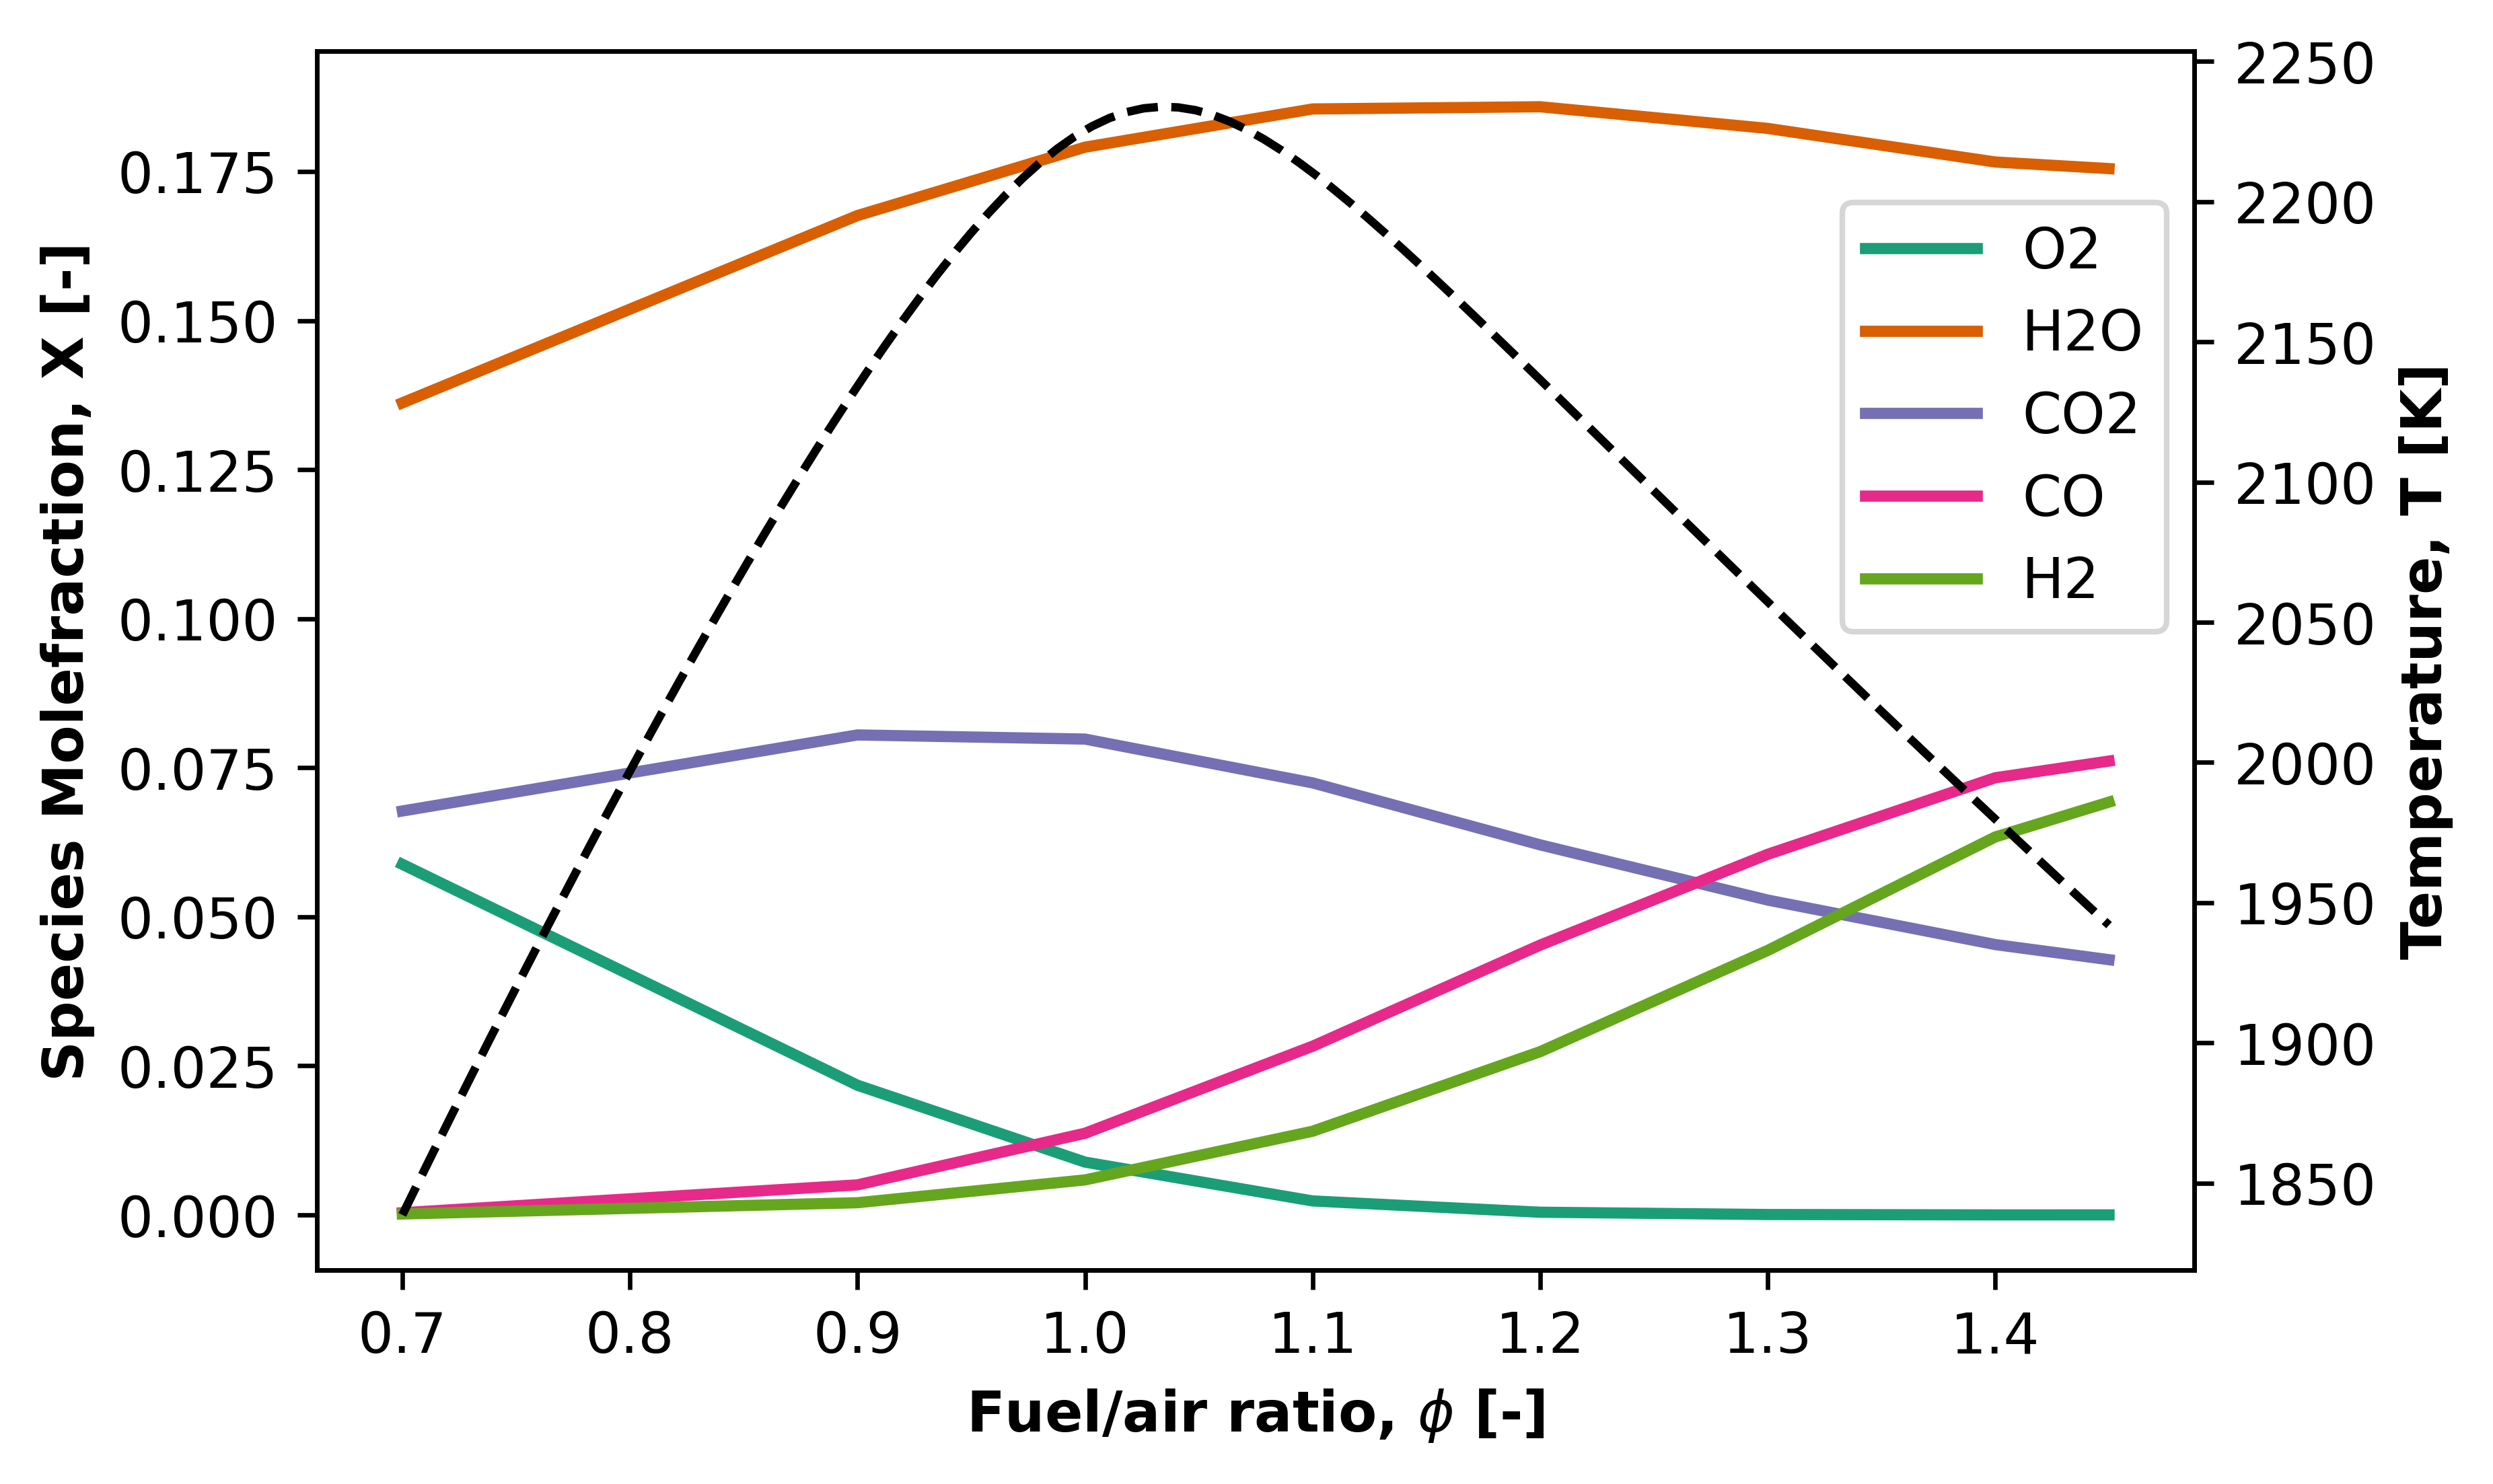

In [112]:
FAR2 = np.linspace(0.7,1.45,100)
T_ad2 = np.zeros(len(FAR2)) #cantera solution

for i,phi in enumerate(FAR2):
       
        ##Cantera solution:
        gas.TPX = T0, p0, 'CH4:%f, O2:2, N2:7.52' % phi
        gas.equilibrate('HP')
        T_ad2[i] = gas.T

plt.figure(dpi=600)
ax1 = sns.lineplot(data=DIBfinal[['O2','H2O','CO2','CO','H2']],dashes=False, lw=2,palette = 'Dark2')
bx1 = ax1.twinx()
sns.lineplot(x=FAR2,y=T_ad2, color="k",ax=bx1)
bx1.lines[0].set_linestyle("--")


ax1.set_xlabel('Fuel/air ratio, $\phi$ [-]',fontsize=10,fontweight='bold')
ax1.set_ylabel('Species Molefraction, X [-]',fontsize=10,fontweight='bold');
bx1.set_ylabel('Temperature, T [K]',fontsize=10,fontweight='bold');

ax1.legend(['O2','H2O','CO2','CO','H2'],loc=7,bbox_to_anchor=(1,0.7));
#plt.savefig("above15mm.png")

#### Velocity and density as a function of z

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


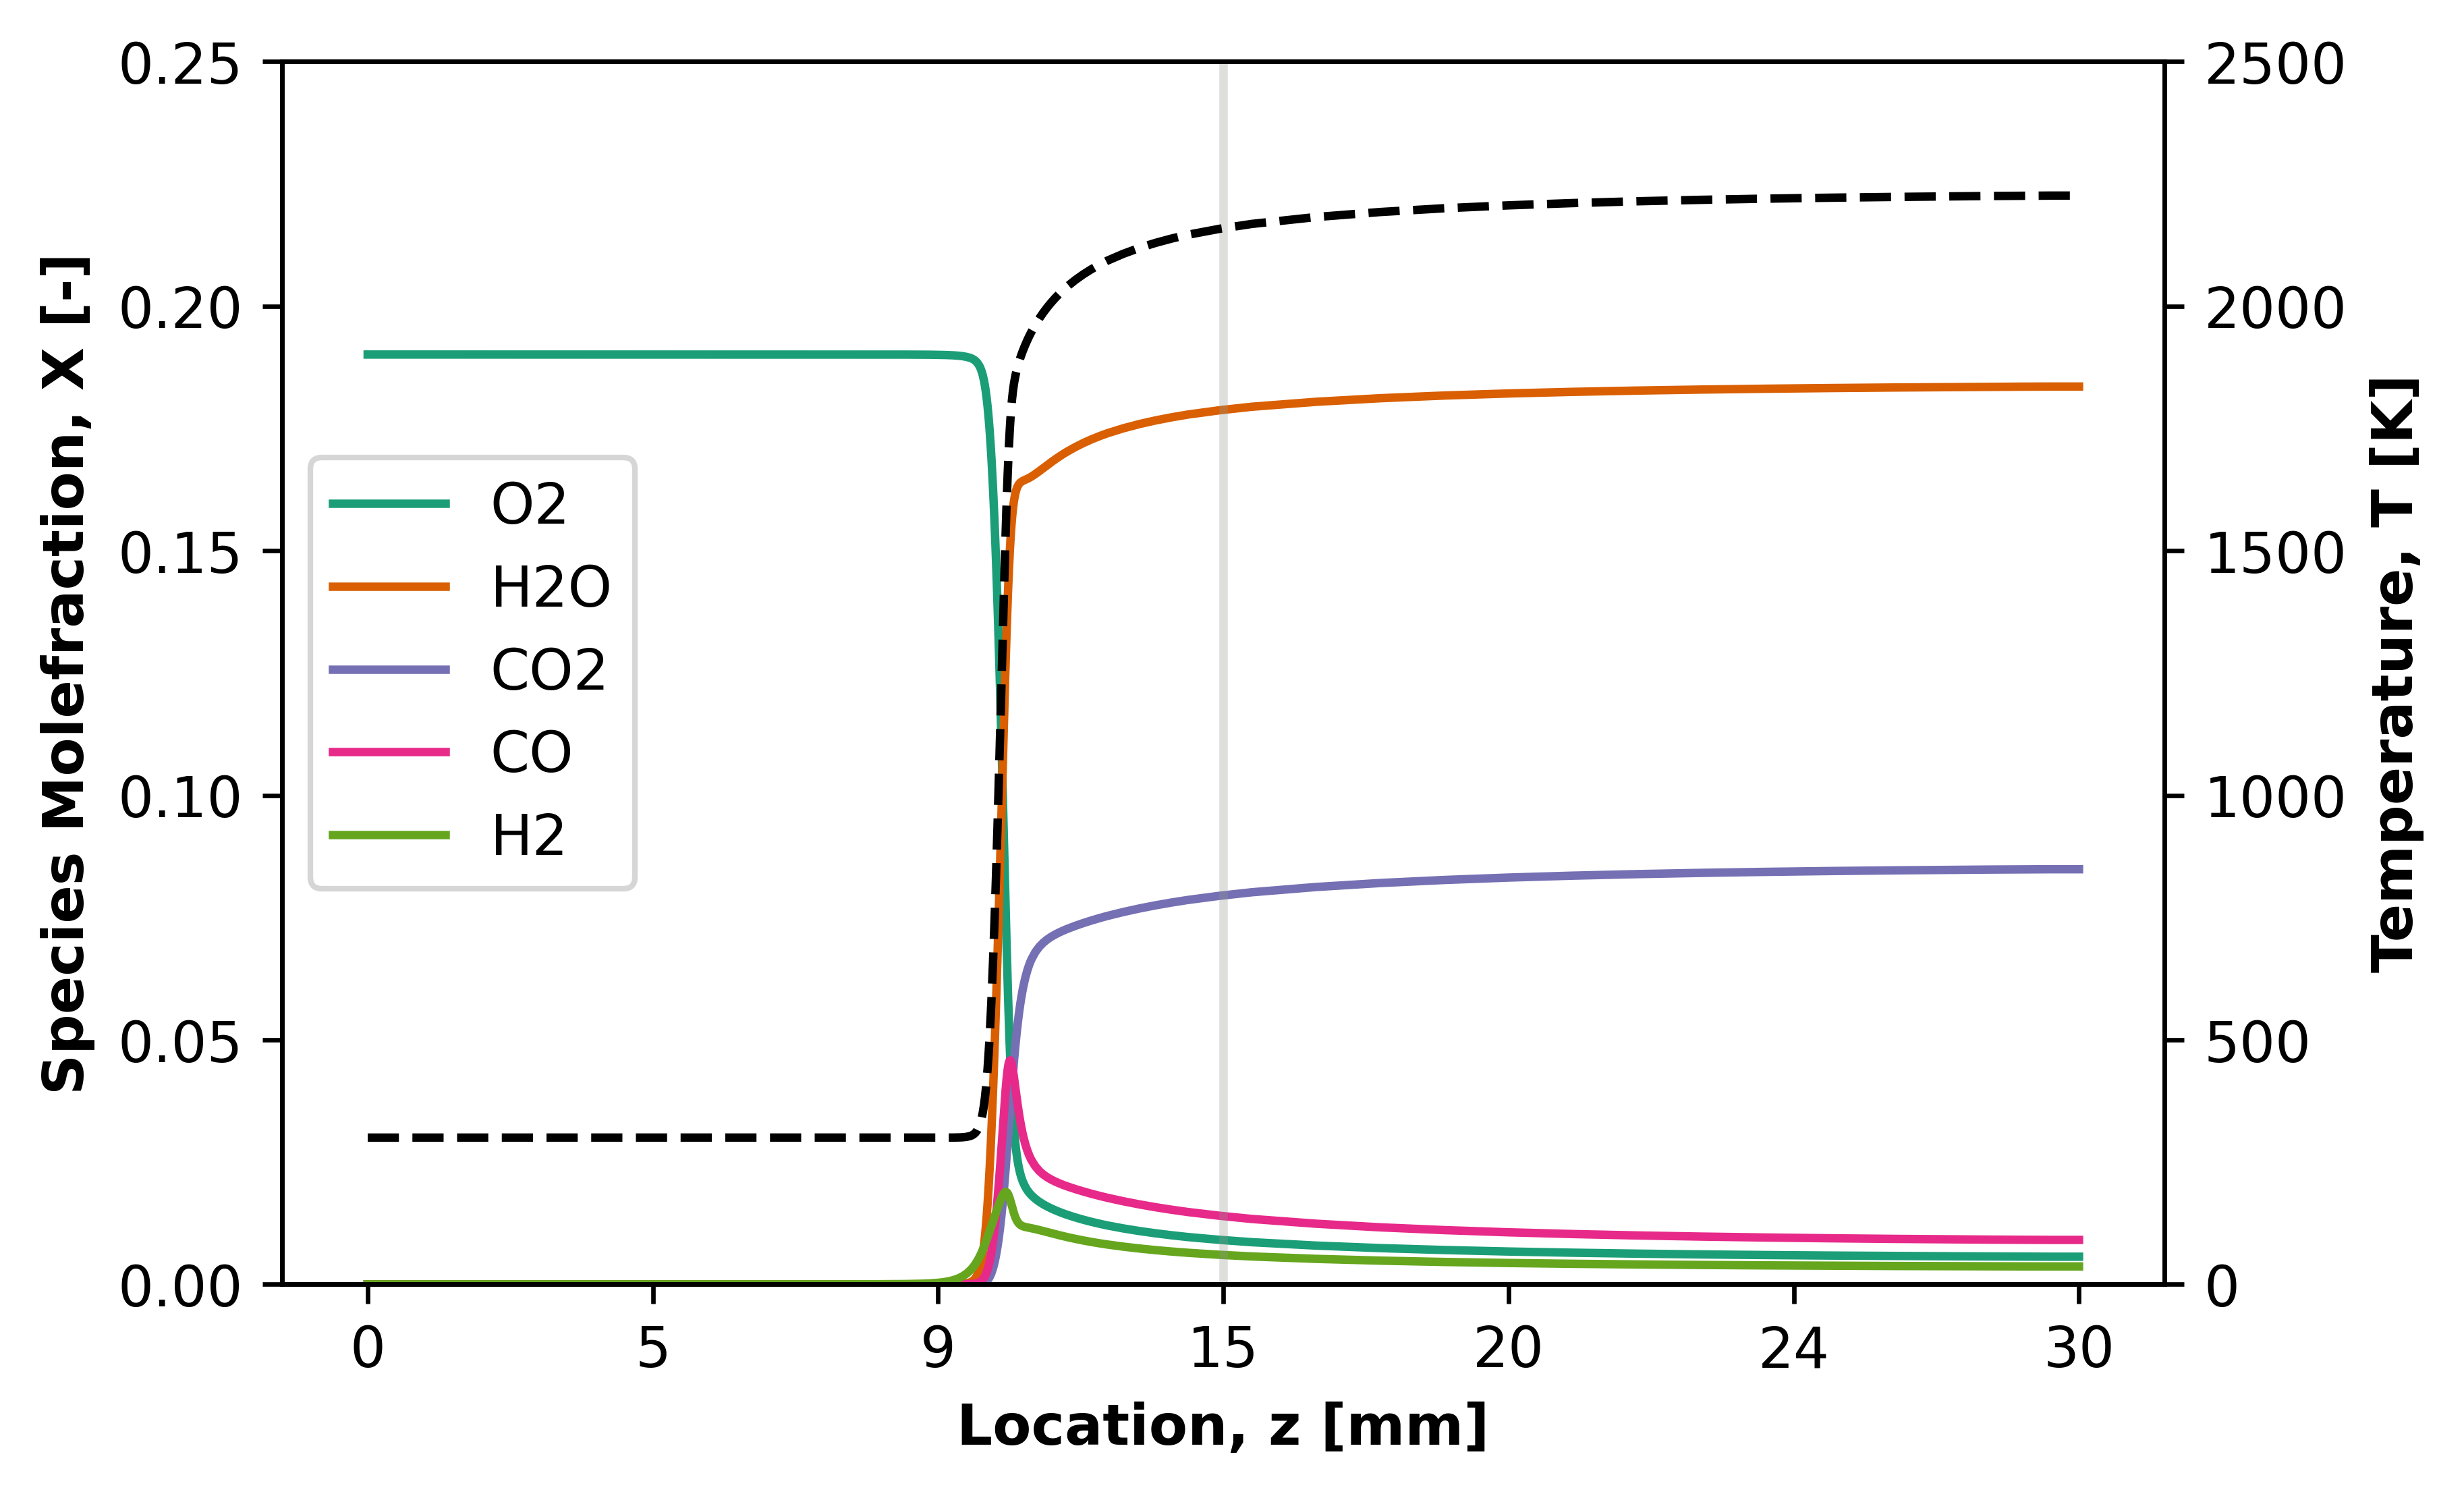

In [105]:
plotdf = DIBdf.groupby('phi').get_group(1.0)
palette = itertools.cycle(sns.color_palette('Dark2'))


plt.figure(dpi=600)
for species in ['O2','H2O','CO2','CO','H2']:
    ax1=sns.lineplot(x='z',y=species, data=plotdf,color=next(palette))

bx1 = ax1.twinx()
sns.lineplot(x='z',y='T', data = plotdf,color="k",ax=bx1)
bx1.lines[0].set_linestyle("--")
bx1.set_ylim(0, 2500)
ax1.set_ylim(0, 0.25)



ticks = ax1.get_xticks()*10**3;
ax1.set_xticklabels(ticks.astype(int));

ax1.set_xlabel('Location, z [mm]',fontsize=10,fontweight='bold')
ax1.set_ylabel('Species Molefraction, X [-]',fontsize=10,fontweight='bold');
bx1.set_ylabel('Temperature, T [K]',fontsize=10,fontweight='bold');

ax1.axvline(0.015,color='xkcd:gray',alpha=0.3)
ax1.legend(['O2','H2O','CO2','CO','H2'],loc=6);
#plt.savefig("stochiospecies.png")

In [110]:
#### Density and velocity as a function of z

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


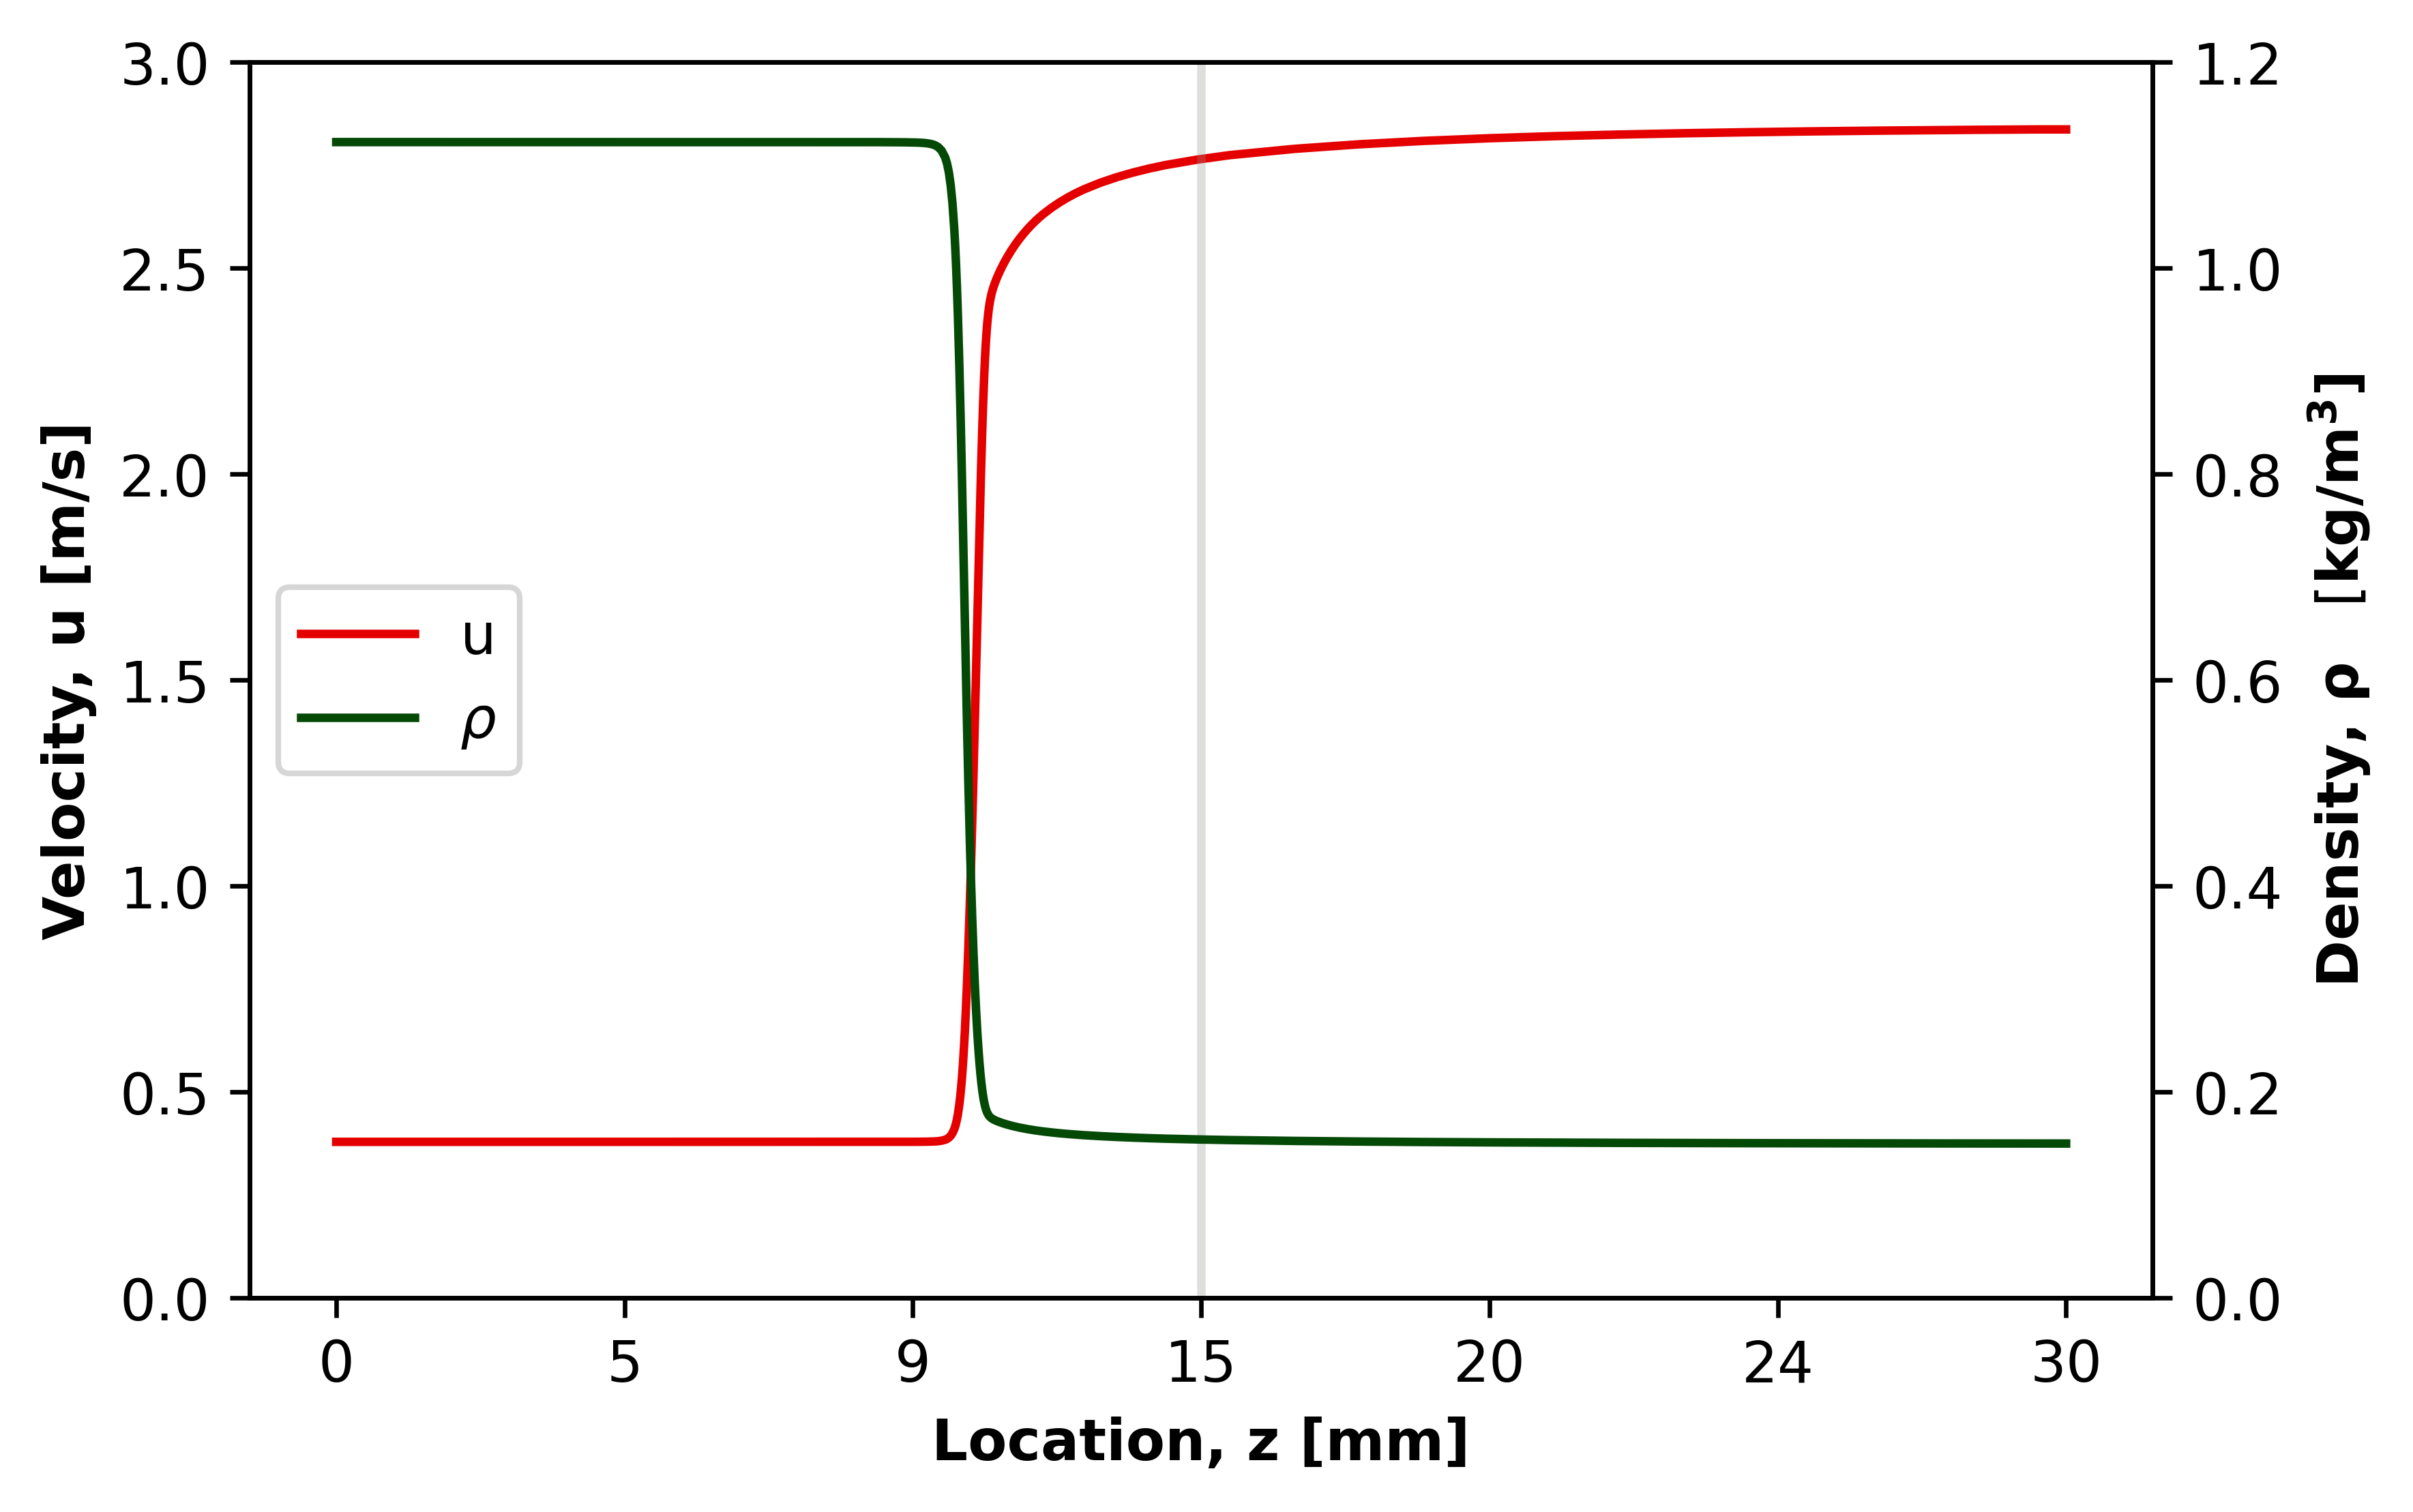

In [106]:
plt.figure(dpi=600)
ax2=sns.lineplot(x='z',y='u', data=plotdf, color='xkcd:red',label='u')
bx2 = ax2.twinx()
lns2 = sns.lineplot(x='z',y='rho', data = plotdf,color='xkcd:darkgreen',ax=bx2,label=r'$\rho$')
bx2.set_ylim(0, 1.2)
ax2.set_ylim(0, 3)
ax2.axvline(0.015,color='xkcd:gray',alpha=0.3)
ticks = ax2.get_xticks()*10**3;
ax2.set_xticklabels(ticks.astype(int));

ax2.set_xlabel('Location, z [mm]',fontsize=10,fontweight='bold')
bx2.set_ylabel(r'Density, $\mathbf{\rho}\quad[\mathrm{\mathbf{kg/m^3]}}$',fontsize=10,fontweight='bold');
ax2.set_ylabel('Velocity, u [m/s]',fontsize=10,fontweight='bold');

h1, l1 = ax2.get_legend_handles_labels()
h2, l2 = bx2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc=6)

bx2.legend([],[], frameon=False)

#plt.savefig("stochiourho.png")